<a href="https://colab.research.google.com/github/28Srushti/Drug-Toxicity-Preditiction/blob/main/Drug_Toxic_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install deepchem

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.3/34.3 MB 47.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import deepchem as dc
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Descriptors, Draw
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [ ]:
# Load Tox21 dataset from CSV
tox21_data = pd.read_csv('/content/sample_data/Drug_Toxic/tox21.csv')
#print("Dataset Columns:", tox21_data.columns)
#print("First 5 Rows:")
print(tox21_data.head())

   NR-AR  NR-AR-LBD  NR-AhR  NR-Aromatase  NR-ER  NR-ER-LBD  NR-PPAR-gamma  \
0    0.0        0.0     1.0           NaN    NaN        0.0            0.0   
1    0.0        0.0     0.0           0.0    0.0        0.0            0.0   
2    NaN        NaN     NaN           NaN    NaN        NaN            NaN   
3    0.0        0.0     0.0           0.0    0.0        0.0            0.0   
4    0.0        0.0     NaN           0.0    0.0        0.0            0.0   

   SR-ARE  SR-ATAD5  SR-HSE  SR-MMP  SR-p53   mol_id  \
0     1.0       0.0     0.0     0.0     0.0  TOX3021   
1     NaN       0.0     NaN     0.0     0.0  TOX3020   
2     0.0       NaN     0.0     NaN     NaN  TOX3024   
3     NaN       0.0     NaN     0.0     0.0  TOX3027   
4     0.0       0.0     0.0     NaN     0.0  TOX3028   

                                              smiles  
0                       CCOc1ccc2nc(S(N)(=O)=O)sc2c1  
1                          CCN1C(=O)NC(c2ccccc2)C1=O  
2  CC[C@]1(O)CC[C@H]2[C@@H]3C

In [ ]:
# Convert SMILES to RDKit Molecule Objects
def smiles_to_mol(smiles):
    try:
        return Chem.MolFromSmiles(smiles)
    except:
        return None

tox21_data['mol'] = tox21_data['smiles'].apply(smiles_to_mol)

# Remove invalid molecules
tox21_data = tox21_data.dropna(subset=['mol'])

[18:01:08] WARNING: not removing hydrogen atom without neighbors
[18:01:08] Explicit valence for atom # 8 Al, 6, is greater than permitted
[18:01:08] Explicit valence for atom # 3 Al, 6, is greater than permitted
[18:01:08] Explicit valence for atom # 4 Al, 6, is greater than permitted
[18:01:09] Explicit valence for atom # 4 Al, 6, is greater than permitted
[18:01:09] Explicit valence for atom # 9 Al, 6, is greater than permitted
[18:01:09] Explicit valence for atom # 5 Al, 6, is greater than permitted
[18:01:09] Explicit valence for atom # 16 Al, 6, is greater than permitted
[18:01:09] Explicit valence for atom # 20 Al, 6, is greater than permitted


In [ ]:
# Extract molecular fingerprints for faster processing
def get_fingerprint(mol):
    from rdkit.Chem import AllChem
    return AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024)

tox21_data['fingerprint'] = tox21_data['mol'].apply(get_fingerprint)

# Remove rows where fingerprints are missing
tox21_data = tox21_data.dropna(subset=['fingerprint'])

Streaming output truncated to the last 5000 lines.
[18:01:12] DEPRECATION WARNING: please use MorganGenerator
[18:01:12] DEPRECATION WARNING: please use MorganGenerator
[18:01:12] DEPRECATION WARNING: please use MorganGenerator
[18:01:12] DEPRECATION WARNING: please use MorganGenerator
[18:01:12] DEPRECATION WARNING: please use MorganGenerator
[18:01:12] DEPRECATION WARNING: please use MorganGenerator
[18:01:12] DEPRECATION WARNING: please use MorganGenerator
[18:01:12] DEPRECATION WARNING: please use MorganGenerator
[18:01:12] DEPRECATION WARNING: please use MorganGenerator
[18:01:12] DEPRECATION WARNING: please use MorganGenerator
[18:01:12] DEPRECATION WARNING: please use MorganGenerator
[18:01:12] DEPRECATION WARNING: please use MorganGenerator
[18:01:12] DEPRECATION WARNING: please use MorganGenerator
[18:01:12] DEPRECATION WARNING: please use MorganGenerator
[18:01:12] DEPRECATION WARNING: please use MorganGenerator
[18:01:12] DEPRECATION WARNING: please use MorganGenerator
[18:0

In [ ]:
# Display Sample Molecule Images with Toxicity Labels
sample_mols = tox21_data['mol'].iloc[:10]
sample_labels = tox21_data.iloc[:10, 1]  # Assuming first label column is toxicity

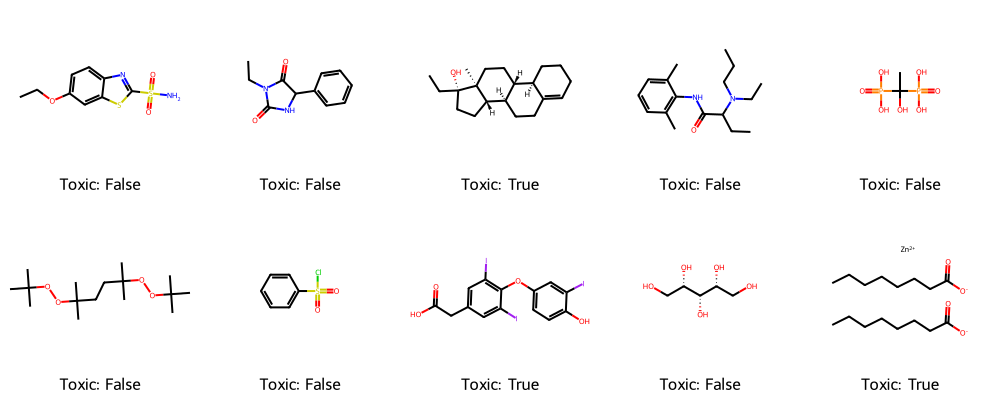

In [ ]:
img = Draw.MolsToGridImage(sample_mols, molsPerRow=5, subImgSize=(200,200), legends=[f"Toxic: {bool(label)}" for label in sample_labels])
display(img)

In [ ]:
# Convert fingerprints to numerical array
X = np.array([list(fp) for fp in tox21_data['fingerprint']])

# Use the first toxicity label column as the target variable
y = tox21_data.iloc[:, 1].values  # Assuming first label column is toxicity

In [ ]:
# Remove NaN values and align X and y correctly
tox21_data = tox21_data.dropna(subset=[tox21_data.columns[1]])
X = X[:len(tox21_data)]  # Ensure X and y have the same length
y = y = y[:len(X)].astype(int) # Convert labels to integer (0 or 1)

<ipython-input-11-0b3102af26d2>:4: RuntimeWarning: invalid value encountered in cast
  y = y = y[:len(X)].astype(int) # Convert labels to integer (0 or 1)


In [ ]:
# Split into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest Classifier
model = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42)

In [ ]:
# Predict on test data
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:, 1]  # Probability of being toxic

In [ ]:
# Evaluate model
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy * 100:.2f}%")
print("Classification Report:\n", classification_report(y_test, y_pred))

Model Accuracy: 84.99%
Classification Report:
                       precision    recall  f1-score   support

-9223372036854775808       0.58      0.10      0.17       196
                   0       0.86      0.99      0.92      1147
                   1       0.68      0.47      0.56        36

            accuracy                           0.85      1379
           macro avg       0.71      0.52      0.55      1379
        weighted avg       0.81      0.85      0.80      1379



In [ ]:
# Identify toxic and non-toxic compounds
toxic_indices = np.where(y_pred == 1)[0]
non_toxic_indices = np.where(y_pred == 0)[0]

toxic_compounds = tox21_data.iloc[toxic_indices]
toxic_probabilities = y_pred_prob[toxic_indices]

non_toxic_count = len(non_toxic_indices)
toxic_count = len(toxic_indices)

In [ ]:
# Convert toxic compounds to molecular formulas
def get_molecular_formula(mol):
    return Chem.rdMolDescriptors.CalcMolFormula(mol)

toxic_formulas = [get_molecular_formula(mol) for mol in toxic_compounds['mol']]

toxic_results = pd.DataFrame({
    'Molecular Formula': toxic_formulas,
    'Toxicity Probability': toxic_probabilities
})

In [ ]:
print(f"Total Non-Toxic Compounds: {non_toxic_count}")
print(f"Total Toxic Compounds: {toxic_count}")
print("\nToxic Compounds and Their Toxicity Levels:\n")
print(toxic_results.head())

Total Non-Toxic Compounds: 1321
Total Toxic Compounds: 25

Toxic Compounds and Their Toxicity Levels:

  Molecular Formula  Toxicity Probability
0        C20H24N2O2                 0.060
1           C12H15N                 0.165
2          C17H21NO                 0.180
3           C3H10N2                 0.065
4          C4H6O4S2                 0.230


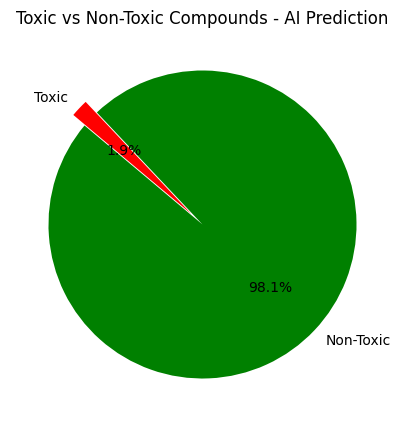

In [ ]:
# Pie Chart Visualization of Toxic vs Non-Toxic
labels = ['Non-Toxic', 'Toxic']
sizes = [non_toxic_count, toxic_count]
colors = ['green', 'red']
explode = (0, 0.1)

plt.figure(figsize=(5, 5))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, explode=explode, startangle=140)
plt.title("Toxic vs Non-Toxic Compounds - AI Prediction")
plt.show()
